Github: https://github.com/Hakonandreas/HakonsApp

Streamlit: https://hakond2dproject.streamlit.app

## Log
Also this assignment I tried to follow the working car principle, to make sure that I always had a working version of the code before adding new features. I started by reading the documentation for the API, and modified the given default code to fit my needs. Then I printed some of the output to understand how it was structured. I then wrapped it as a function as mentioned in the assignment. When working with anomaly detection I started by plotting the raw graph and the SATV, just for a reference for myself, even though it was told not to. Then I implemented the function where the outlier boundaries where plotted. I struggled a bit to make the boundaries fluctuate correctly with the graph as done in lectures, but with some help from ChatGPT I managed to get it to work. 

I chose to load the elhub data from my mongodb. I struggled a bit to work with this as a used the eduroam network, so I instead had to work on this from home. To make sure I had a working version of the code, I first fetched the data from mongodb and printed some of it to understand how it was structured. Then I wrapped it as a function as mentioned in the assignment. Finally I plotted the data to see that it worked as intended. 

In streamlit I started by making some global functions to retrieve the API from open-meteo(that earlier was based on the csv) and elhub data from mongodb. The though was that I did not have to retrieve this in every page, as all of them was based on this data. After I got this to work on my existing code, I followed my working car principle further and started to work on the New A. When it worked on the data itself, I tried to implement the session state from the first page, such that the page was based on the area selector on that page. As this worked fine, I did the same for New B. At the start I struggled a bit with the fact that you had to open the Elhub page first, such that the session state was loaded. But after referring with chatGPT I found that I could set a default on my main .py file, such that it always was an area selected. This worked well!


## AI usage
First, I generally have copilot enabled in VS code to efficiently write code. In addition, I used ChatGPT to clarify concepts, create parts of the code and debug errors. I made sure to be actively involved in the code, and only used AI to assist me in the process. I also made sure to review all code generated by AI. More concretely tasks where I used AI was to find the longitude and latitude of the cities given. Later I especially needed help from AI, to make the anomaly upper and lower boundaries fluctuate with the graph as I struggled with some unknown errors when I tried to fix when it was static and horizontal.

In streamlit I used AI in the same matter as the ipynb. Some of my main usage area was to try to implement the functions that I had working in my notebook, such that they worked in a similar way in streamlit. This way I ensured that I based my streamlit functions on already working functions. As mentioned in the log I also referred with chatGPT on how I could avoid that you had to start on page 1 etc. I therefore got the suggestion to set a default in my main page. When it comes to my own functions for API and mongoDB I based it on my existing code, so I did that mostly on my own in the same way as before. There I used ChatGPT mostly to brush up the function for a smoother generalization, and to make sure that my cache worked as it was supposed to. 

In [1]:
import openmeteo_requests
import pandas as pd
import requests_cache
from retry_requests import retry
import plotly.express as px
from scipy.fftpack import dct, idct
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
import toml
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import STL
from scipy.signal import spectrogram
from IPython.display import Image, display

## API-connection 
Based on the Open-Meteo template

In [2]:
# City and price area information
areas_df = pd.DataFrame({
    "price_area": ["NO1", "NO2", "NO3", "NO4", "NO5"],
    "city": ["Oslo", "Kristiansand", "Trondheim", "Tromsø", "Bergen"],
    "latitude": [59.91, 58.15, 63.43, 69.65, 60.39],
    "longitude": [10.75, 7.99, 10.40, 18.96, 5.32]
})

# Display DataFrame
print(areas_df)


  price_area          city  latitude  longitude
0        NO1          Oslo     59.91      10.75
1        NO2  Kristiansand     58.15       7.99
2        NO3     Trondheim     63.43      10.40
3        NO4        Tromsø     69.65      18.96
4        NO5        Bergen     60.39       5.32


In [3]:

# Function to retrieve coordinates for a given city
def get_city_coords(city_name: str):
    """Return latitude and longitude for a given Norwegian city name."""
    city_row = areas_df.loc[areas_df["city"].str.lower() == city_name.lower()]
    if city_row.empty:
        raise ValueError(f"City '{city_name}' not found in price area list.")
    lat = city_row["latitude"].values[0]
    lon = city_row["longitude"].values[0]
    return lat, lon


# Function to download ERA5 data
def download_era5_data(latitude: float, longitude: float, year: int) -> pd.DataFrame:
    """
    Download historical ERA5 reanalysis data from Open-Meteo
    for a specific latitude, longitude, and year.
    The variables match those in open-meteo-subset.csv.
    """

    # Setup API client with caching and retry mechanism
    cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)

    # API parameters
    url = "https://archive-api.open-meteo.com/v1/era5"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": f"{year}-01-01",
        "end_date": f"{year}-12-31",
        "hourly": [
            "temperature_2m",
            "precipitation",
            "wind_speed_10m",
            "wind_gusts_10m",
            "wind_direction_10m"
        ],
        "timezone": "Europe/Oslo"
    }

    # Request data
    responses = openmeteo.weather_api(url, params=params)
    response = responses[0]

    # Extract hourly data
    hourly = response.Hourly()
    variables = params["hourly"]

    hourly_data = {
        "time": pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left"
        )
    }

    for i, var in enumerate(variables):
        hourly_data[var] = hourly.Variables(i).ValuesAsNumpy()

    df = pd.DataFrame(hourly_data)
    df["latitude"] = latitude
    df["longitude"] = longitude

    print(f"ERA5 data downloaded for ({latitude}, {longitude}) in {year}")
    print(f"Elevation: {response.Elevation()} m | Timezone: {response.Timezone()} ({response.TimezoneAbbreviation()})")

    return df


# Step 4: Apply for Bergen (2019)
city = "Bergen"
year = 2019

lat, lon = get_city_coords(city)
print(f"Downloading ERA5 data for {city} ({lat}, {lon}) in {year}...")

bergen_2019 = download_era5_data(lat, lon, year)

print(bergen_2019.head())



ERA5 data downloaded for (60.39, 5.32) in 2019
Elevation: 17.0 m | Timezone: b'Europe/Oslo' (b'GMT+1')
                       time  temperature_2m  precipitation  wind_speed_10m  \
0 2018-12-31 23:00:00+00:00           5.672            0.7       36.973244   
1 2019-01-01 00:00:00+00:00           5.772            0.2       41.036842   
2 2019-01-01 01:00:00+00:00           6.072            0.7       42.033756   
3 2019-01-01 02:00:00+00:00           6.322            0.5       40.913490   
4 2019-01-01 03:00:00+00:00           5.822            1.1       41.238468   

   wind_gusts_10m  wind_direction_10m  latitude  longitude  
0       99.720001          263.290253     60.39       5.32  
1      107.279991          277.561340     60.39       5.32  
2      111.959999          286.417297     60.39       5.32  
3      105.839996          298.368958     60.39       5.32  
4      110.159996          315.000092     60.39       5.32  


## Outliers and Anomalies Detection

In [4]:
# Extract temperature as a numpy array
temp = bergen_2019["temperature_2m"].values

# Apply Discrete Cosine Transform (DCT)
temp_dct = dct(temp, norm='ortho')

# High-pass filter: remove the lowest frequency components (seasonal trend)
cutoff = int(len(temp) * 0.01)  # keep top 99% of frequencies
temp_dct[:cutoff] = 0

# Inverse DCT to reconstruct the high-frequency signal
temp_satv = idct(temp_dct, norm='ortho')

# Store results
bergen_2019["SATV"] = temp_satv

# Plot both original and SATV
fig = px.line(
    bergen_2019,
    x="time",
    y=["temperature_2m", "SATV"],
    title=f"Temperature and Seasonally Adjusted Temperature Variation (SATV) — {city} {year}"
)
fig.update_layout(yaxis_title="Temperature (°C)")
fig.show()


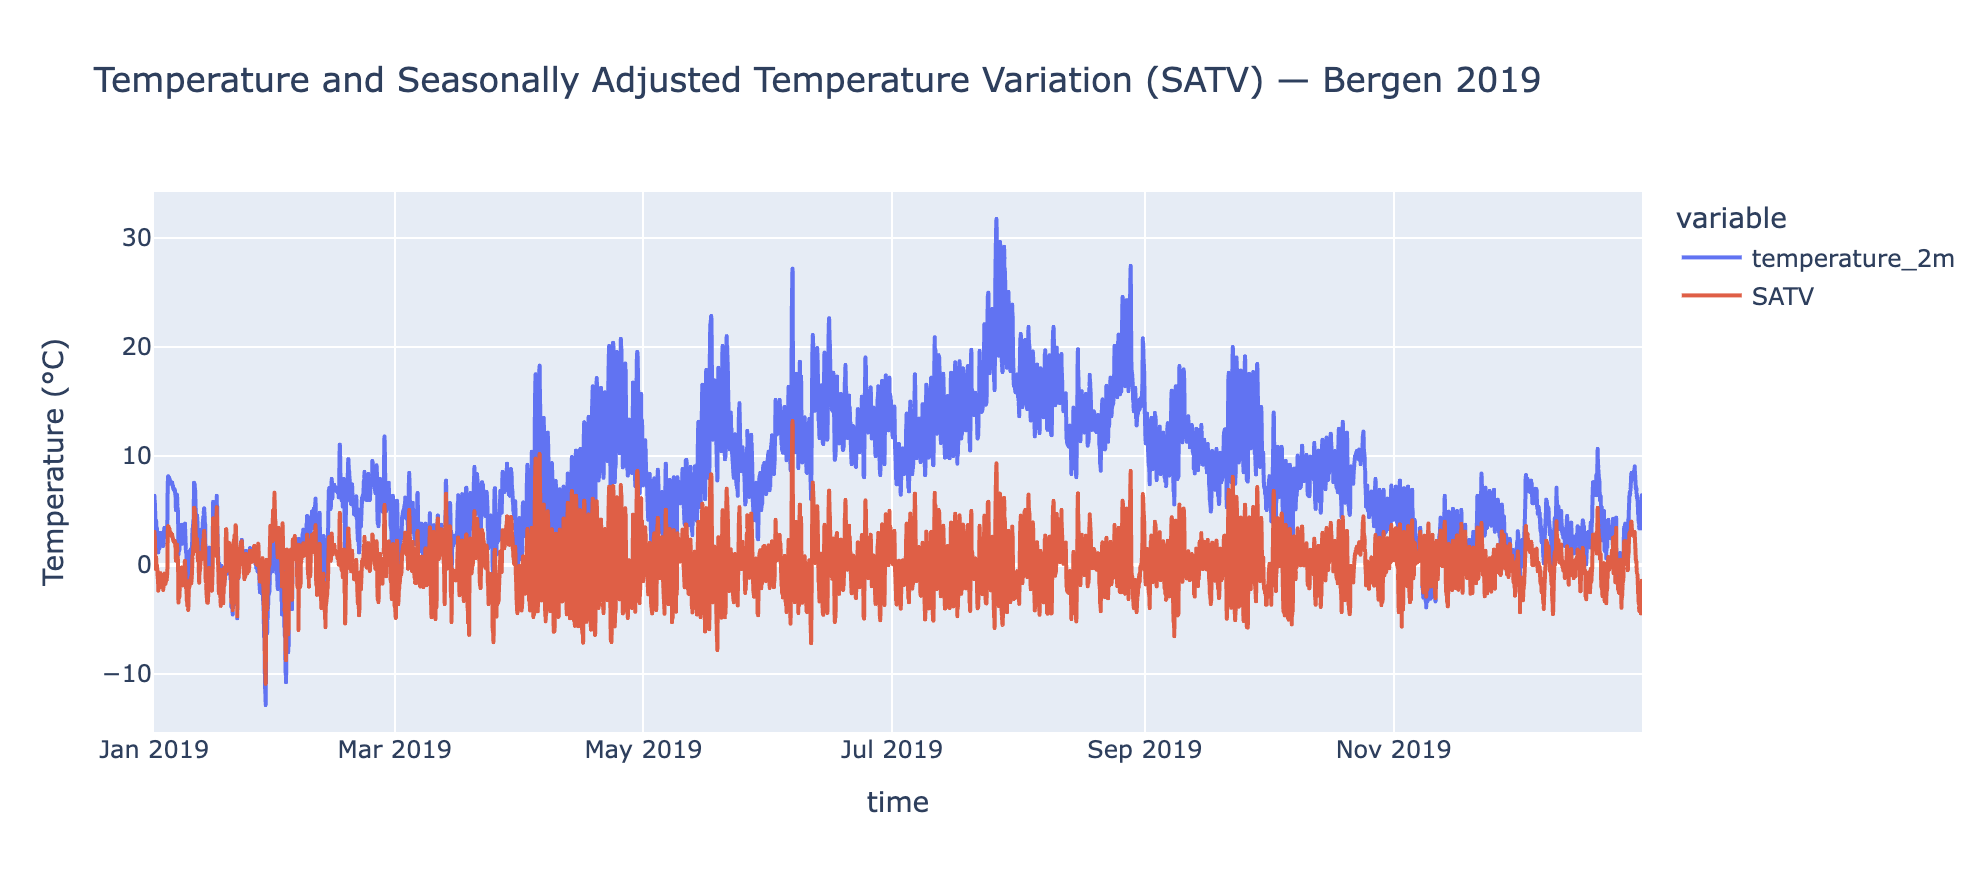

In [5]:
# Display plot to show in pdf
display(Image(filename='Data_plot.png'))

In [6]:
def plot_temperature_spc_dynamic(df, temp_col="temperature_2m", time_col="time", 
                                 cutoff_frac=0.01, n_std=3, city="Bergen", year=2019):
    temp = df[temp_col].values

    # Compute high-pass (SATV)
    temp_dct = dct(temp, norm='ortho')
    cutoff = int(len(temp) * cutoff_frac)
    
    # Create low-pass (seasonal trend)
    temp_dct_low = np.copy(temp_dct)
    temp_dct_low[cutoff:] = 0
    trend = idct(temp_dct_low, norm='ortho')
    
    # High-pass = original - trend
    satv = temp - trend
    df["SATV"] = satv
    df["Trend"] = trend

    # SPC limits based on SATV
    median_satv = np.median(satv)
    mad_satv = np.median(np.abs(satv - median_satv))
    ucl = median_satv + n_std * mad_satv
    lcl = median_satv - n_std * mad_satv

    # Dynamic boundaries following the trend
    df["UCL"] = df["Trend"] + ucl
    df["LCL"] = df["Trend"] + lcl

    # Identify outliers based on dynamic limits
    df["outlier"] = (df[temp_col] > df["UCL"]) | (df[temp_col] < df["LCL"])
    outliers = df[df["outlier"]]

    # Plot
    fig = px.line(
        df, x=time_col, y=temp_col,
        title=f"Temperature with SPC Outlier Detection — {city} {year}",
        labels={temp_col: "Temperature (°C)"}
    )

    # Add dynamic SPC curves
    fig.add_scatter(x=df[time_col], y=df["UCL"], mode="lines",
                    name="UCL", line=dict(color="red", dash="dash"))
    fig.add_scatter(x=df[time_col], y=df["LCL"], mode="lines",
                    name="LCL", line=dict(color="red", dash="dash"))
    
    # Add outliers
    fig.add_scatter(
        x=outliers[time_col],
        y=outliers[temp_col],
        mode="markers",
        name="Outliers",
        marker=dict(color="red", size=6, symbol="x")
    )

    return fig, outliers[[time_col, temp_col, "SATV", "UCL", "LCL"]]

# Testing the dynamic SPC function
fig_temp, out_temp = plot_temperature_spc_dynamic(bergen_2019, city="Bergen", year=2019)
fig_temp.show()
print("Temperature Outliers Summary:")
print(out_temp.head())

Temperature Outliers Summary:
                         time  temperature_2m      SATV       UCL       LCL
236 2019-01-10 19:00:00+00:00           7.522  5.218940  7.246976 -2.718070
237 2019-01-10 20:00:00+00:00           7.472  5.179501  7.236415 -2.728631
238 2019-01-10 21:00:00+00:00           7.472  5.189675  7.226240 -2.738806
239 2019-01-10 22:00:00+00:00           7.372  5.099468  7.216447 -2.748599
240 2019-01-10 23:00:00+00:00           7.322  5.058885  7.207030 -2.758016


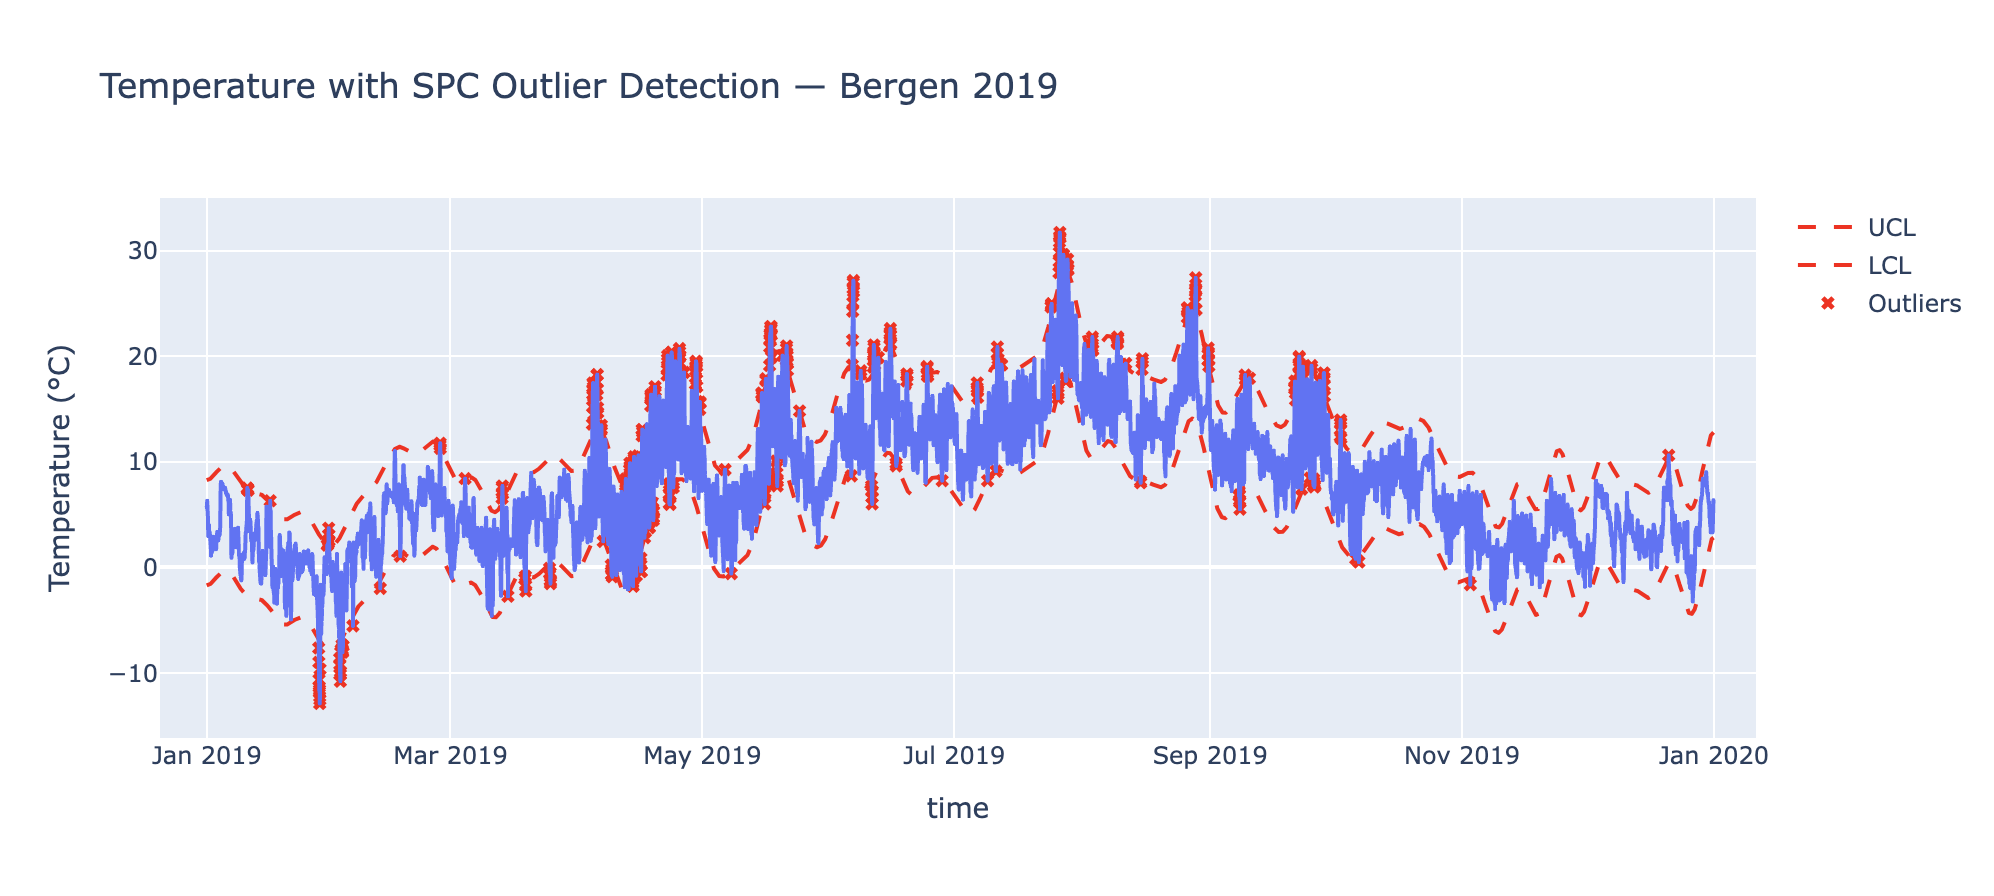

In [7]:
# Display plot to show in pdf
display(Image(filename='SPC_outlier.png'))

In [8]:
# Precipitation with LOF
def plot_precipitation_lof(df, prec_col="precipitation", time_col="time", 
                           outlier_frac=0.01, city="Bergen", year=2019):
    """
    Plot precipitation and highlight anomalies using Local Outlier Factor.
    
    Parameters:
    - df: pandas DataFrame with precipitation and time
    - prec_col: name of precipitation column
    - time_col: name of time column
    - outlier_frac: proportion of data considered as outliers
    - city, year: for plot title
    
    Returns:
    - fig: plotly figure
    - outlier_summary: DataFrame of outliers
    """
    values = df[[prec_col]].values
    lof = LocalOutlierFactor(n_neighbors=20, contamination=outlier_frac)
    outlier_labels = lof.fit_predict(values)
    df["outlier"] = outlier_labels == -1
    outliers = df[df["outlier"]]
    
    # Plot precipitation
    fig = px.line(
        df, x=time_col, y=prec_col,
        title=f"Precipitation with LOF Outliers — {city} {year}",
        labels={prec_col: "Precipitation (mm)"}
    )
    
    # Highlight outliers
    fig.add_scatter(
        x=outliers[time_col],
        y=outliers[prec_col],
        mode="markers",
        name="Outliers",
        marker=dict(color="red", size=6, symbol="x")
    )
    
    outlier_summary = outliers[[time_col, prec_col]]
    return fig, outlier_summary



# Precipitation
fig_prec, out_prec = plot_precipitation_lof(bergen_2019, city="Bergen", year=2019)
fig_prec.show()
print("Precipitation Outliers Summary:")
print(out_prec.head())

/Users/hakhol/miniconda3/envs/D2D_env/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:322: UserWarning:

Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.



Precipitation Outliers Summary:
                          time  precipitation
88   2019-01-04 15:00:00+00:00            2.3
477  2019-01-20 20:00:00+00:00            3.8
1026 2019-02-12 17:00:00+00:00            3.3
1565 2019-03-07 04:00:00+00:00            3.4
1696 2019-03-12 15:00:00+00:00            2.3


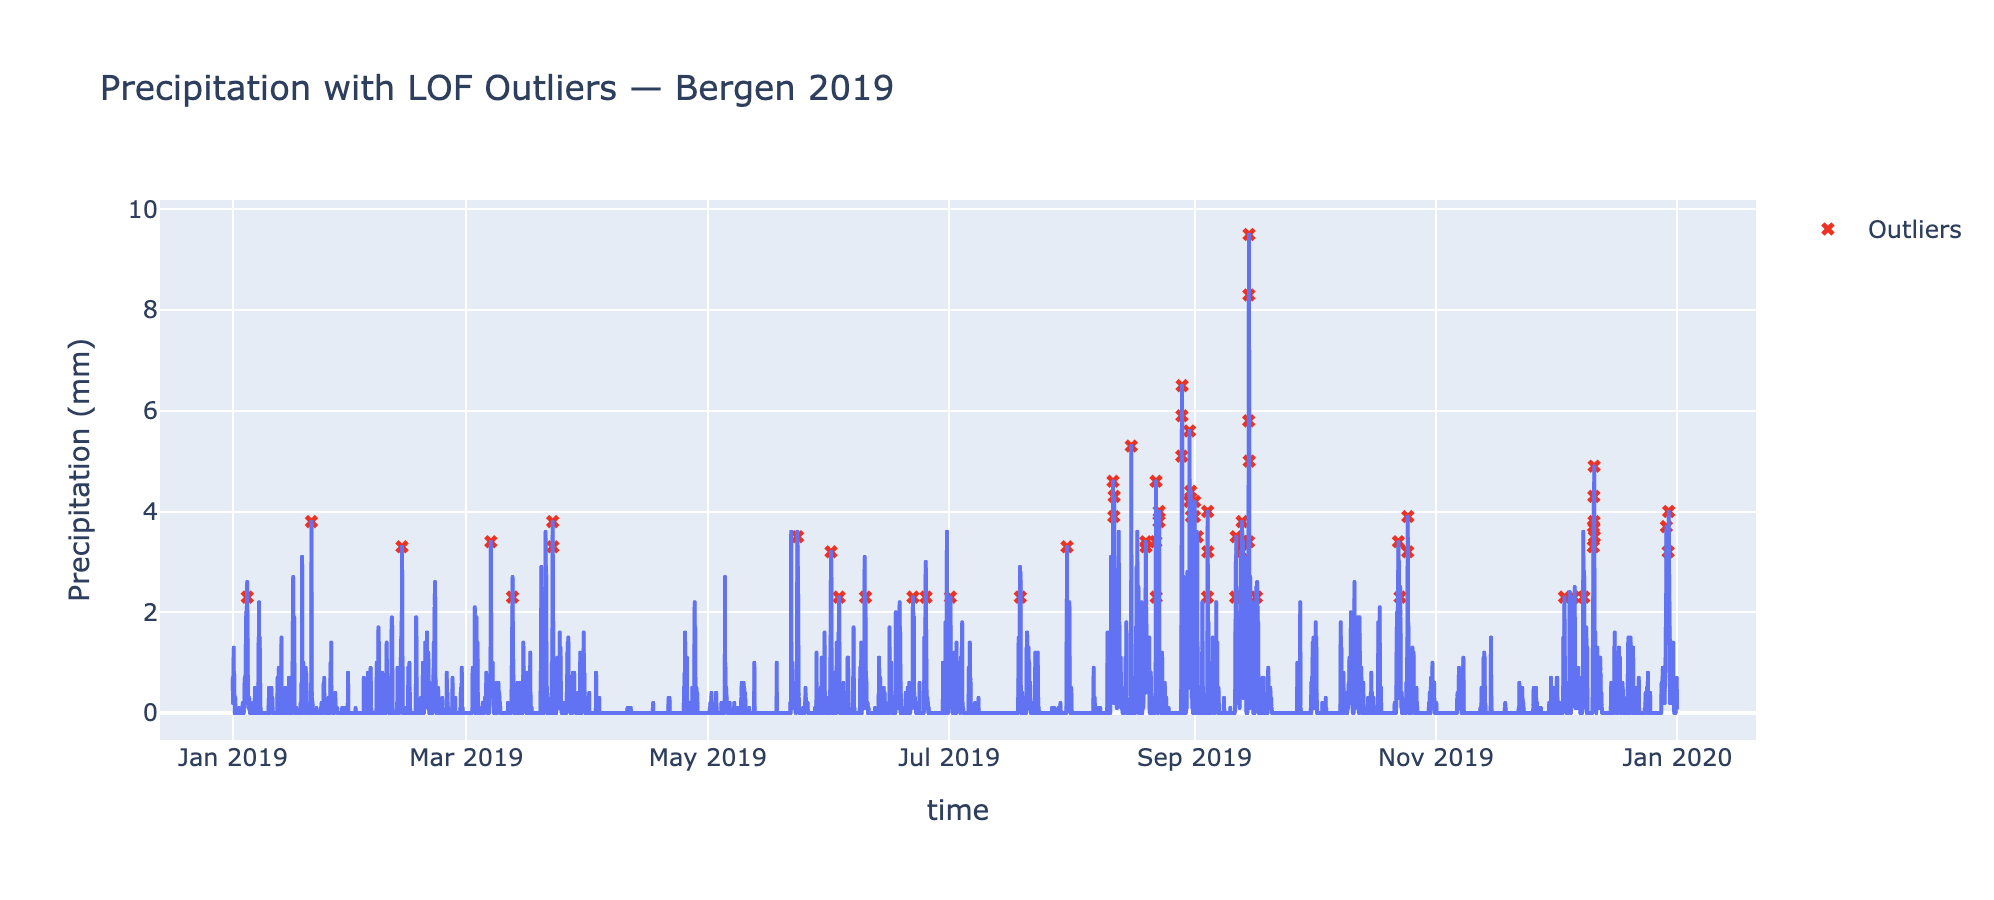

In [9]:
# Display plot to show in pdf
display(Image(filename='Precipitation.png'))

## Seasonal trend decomposition (STL)

In [10]:
# Connection URI
secrets = toml.load("../../secrets.toml")
uri = secrets['mongodb']['uri']

# Create a new client and connect to the server
client = MongoClient(uri, server_api=ServerApi('1'))

# Send a ping to confirm a successful connection
try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)

Pinged your deployment. You successfully connected to MongoDB!


In [11]:
db = client["elhub_db"]
collection = db["production"]

# Fetch all documents
cursor = collection.find()

# Convert to DataFrame
fetched_df = pd.DataFrame(list(cursor))

# Optionally drop the MongoDB-generated _id column
fetched_df = fetched_df.drop(columns=['_id'], errors='ignore')

print(f"Fetched {len(fetched_df)} documents from MongoDB")
print(fetched_df.head())


Fetched 430706 documents from MongoDB
  pricearea productiongroup           starttime  quantitykwh
0       NO3           solar 2021-12-11 19:00:00       15.286
1       NO5           solar 2021-02-06 08:00:00        0.001
2       NO1           solar 2021-02-07 12:00:00      557.771
3       NO3            wind 2021-07-05 14:00:00   230130.600
4       NO2           solar 2021-11-24 23:00:00       32.783


In [12]:
def stl_decomposition(
    pricearea="NO1",
    productiongroup="hydro",
    period=None,
    seasonal=None,
    trend=None,
    robust=True
):
    """
    Perform STL decomposition on Elhub production data.
    Automatically handles irregular time steps by resampling hourly.
    """

    # Connect to MongoDB
    secrets = toml.load("../../secrets.toml")
    uri = secrets['mongodb']['uri']
    client = MongoClient(uri, server_api=ServerApi('1'))
    db = client["elhub_db"]
    collection = db["production"]

    # Fetch data
    query = {"pricearea": pricearea, "productiongroup": productiongroup}
    cursor = collection.find(query, {"_id": 0})
    df = pd.DataFrame(list(cursor))

    if df.empty:
        raise ValueError(f"No data found for pricearea={pricearea}, productiongroup={productiongroup}")

    # Prepare data
    df["starttime"] = pd.to_datetime(df["starttime"])
    df = df.sort_values("starttime").drop_duplicates(subset=["starttime"])
    df = df.set_index("starttime")

    # Keep only the numeric column for resampling
    if "quantitykwh" not in df.columns:
        raise KeyError("Expected column 'quantitykwh' not found in the dataset")

    df = df[["quantitykwh"]].resample("H").mean().interpolate()

    # Set parameters dynamically
    period = period or 24 * 7        # one week
    trend = trend or period * 2 + 1  # must be odd and > period
    if trend % 2 == 0:
        trend += 1
    seasonal = seasonal or 13

    print(f"Using period={period}, trend={trend}, seasonal={seasonal}")
    print(f"Data points: {len(df)}")

    # Perform STL decomposition
    stl = STL(df["quantitykwh"], period=period, seasonal=seasonal, trend=trend, robust=robust)
    res = stl.fit()

    # Plot
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df.index, y=df["quantitykwh"], name="Observed", line=dict(color="black")))
    fig.add_trace(go.Scatter(x=df.index, y=res.trend, name="Trend", line=dict(color="blue")))
    fig.add_trace(go.Scatter(x=df.index, y=res.seasonal, name="Seasonal", line=dict(color="green")))
    fig.add_trace(go.Scatter(x=df.index, y=res.resid, name="Residual", line=dict(color="red")))

    fig.update_layout(
        title=f"STL Decomposition — {productiongroup.capitalize()} ({pricearea})",
        xaxis_title="Date",
        yaxis_title="Production (kWh)",
        template="plotly_white"
    )

    return fig


In [13]:
fig = stl_decomposition(pricearea="NO1", productiongroup="hydro")
fig.show()


/var/folders/2m/kyt8xpwd7xd43s4z7s7gnsdw0000gn/T/ipykernel_94881/2971118279.py:38: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



Using period=168, trend=337, seasonal=13
Data points: 8760


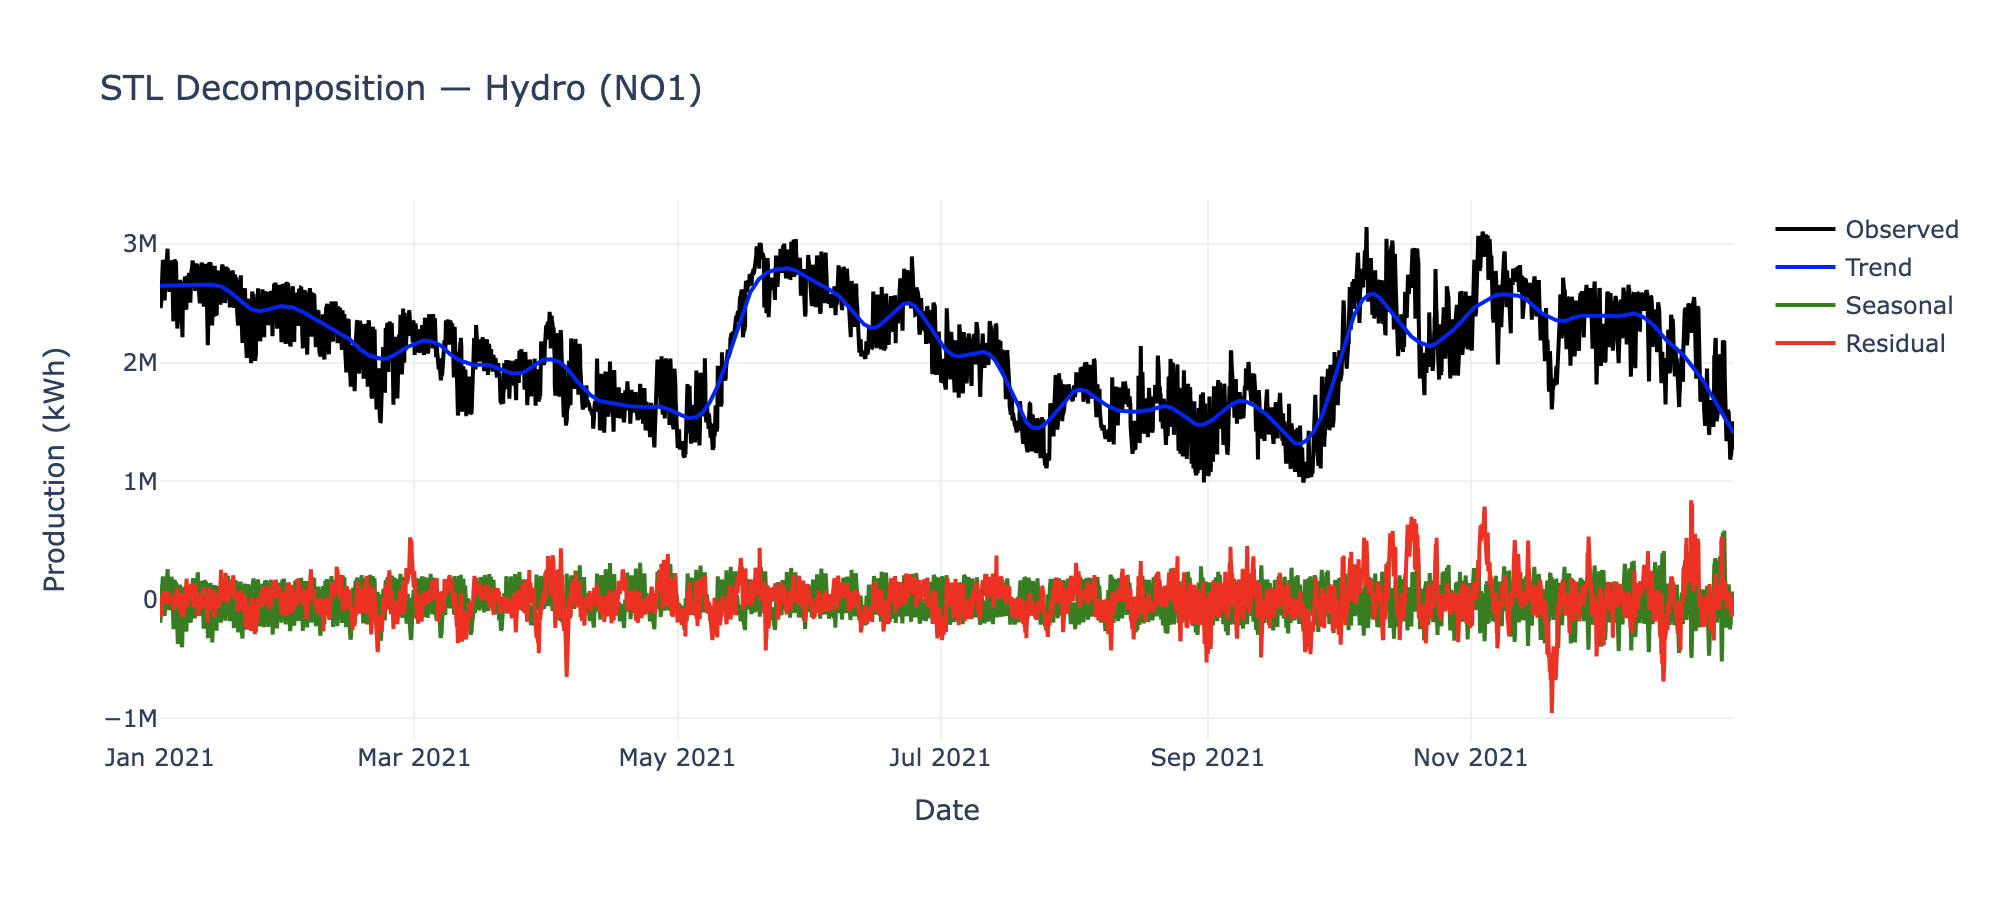

In [14]:
# Display plot to show in pdf
display(Image(filename='STL_decomposition.png'))

## Spectogram

In [15]:
def production_spectrogram(
    pricearea="NO1",
    productiongroup="hydro",
    window_length=168,   # in hours (1 week)
    overlap=0.5          # fraction (e.g. 0.5 means 50% overlap)
):
    """
    Create a spectrogram from Elhub production data.

    Parameters:
        pricearea (str): Electricity price area (e.g. "NO1")
        productiongroup (str): Production group (e.g. "hydro")
        window_length (int): Window length in hours
        overlap (float): Fractional overlap between windows (0–1)

    Returns:
        fig (plotly.graph_objects.Figure): Spectrogram plot
    """

    # Connect to MongoDB
    secrets = toml.load("../../secrets.toml")
    uri = secrets['mongodb']['uri']
    client = MongoClient(uri, server_api=ServerApi('1'))
    db = client["elhub_db"]
    collection = db["production"]

    # Fetch data
    query = {"pricearea": pricearea, "productiongroup": productiongroup}
    cursor = collection.find(query, {"_id": 0})
    df = pd.DataFrame(list(cursor))

    if df.empty:
        raise ValueError(f"No data found for pricearea={pricearea}, productiongroup={productiongroup}")

    # Prepare data
    df["starttime"] = pd.to_datetime(df["starttime"])
    df = df.sort_values("starttime").drop_duplicates(subset=["starttime"])
    df = df.set_index("starttime")[["quantitykwh"]].resample("H").mean().interpolate()

    # Compute spectrogram
    signal = df["quantitykwh"].values
    fs = 1.0  # samples per hour
    nperseg = int(window_length)
    noverlap = int(window_length * overlap)

    freqs, times, Sxx = spectrogram(signal, fs=fs, nperseg=nperseg, noverlap=noverlap)

    # Convert power to dB scale for visualization
    Sxx_dB = 10 * np.log10(Sxx + 1e-10)

    # Convert time indices back to actual datetimes
    times_dt = df.index[0] + pd.to_timedelta(times, unit="h")

    # Create plotly figure
    fig = go.Figure(
        data=go.Heatmap(
            z=Sxx_dB,
            x=times_dt,
            y=freqs,
            colorscale="Viridis",
            colorbar=dict(title="Power (dB)")
        )
    )

    fig.update_layout(
        title=f"Spectrogram — {productiongroup.capitalize()} ({pricearea})",
        xaxis_title="Time",
        yaxis_title="Frequency (cycles/hour)",
        template="plotly_white"
    )

    return fig


In [16]:
fig = production_spectrogram(pricearea="NO1", productiongroup="hydro")
fig.show()

/var/folders/2m/kyt8xpwd7xd43s4z7s7gnsdw0000gn/T/ipykernel_94881/1822670500.py:38: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



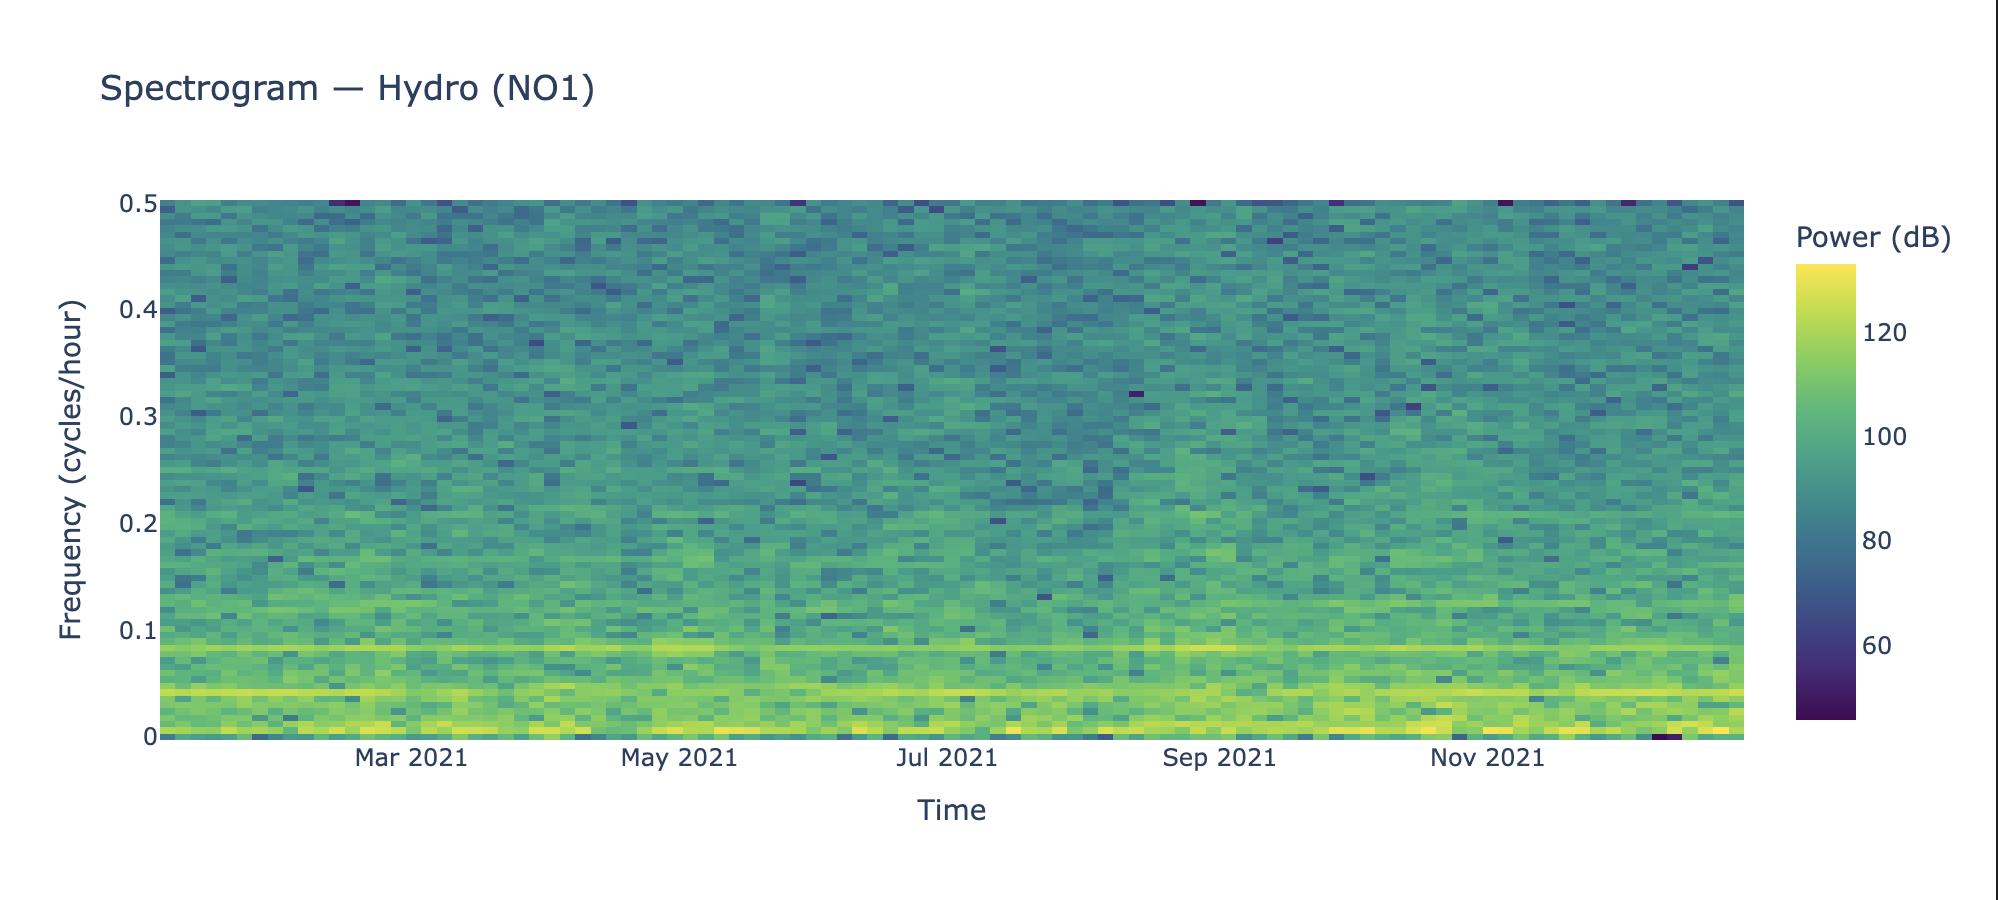

In [17]:
# Display plot to show in pdf
display(Image(filename='Spectrogram.png'))